## Modeling, Feature Engineering, & Feature Selection

### Abstract
Notebook reads in previously processed data, further reduces features and outputs saved datasets in a format that can be uploaded to kaggle for submission.

This notebook outlines the process I went through and tools I used to create a baseline model and improve on it for the kaggle competition. Feature selection, feature engineering, and model comparison are its primary uses. 

### Load Data & Import Libraries

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline

In [3]:
df = pd.read_csv('./datasets/preprocessed_data.csv')
holdout = pd.read_csv('./datasets/preprocessed_holdout.csv')

### Modeling
Below cells are for the easy comparison of performance between models. Metrics used to judge performance are RMSE, r2 on testing data, and r2 on training data.

##### Model Comparison
The below class is for comparing the performance of lasso and ridge, using pipeline and girdsearch. The class is instantiated with your X and y columns. Then you can call each regression model with a parameter grid you would lie to gridsearch over. The metrics for the best model are printed and allows access to the instance of the model for submission to kaggle.

In [11]:
class model_comparison:
    # train test split 
    def __init__(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                           random_state = 25)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
    def lasso(self, params):
        # performs lasso regression 
        # create a pipeline to perform in order
        # reference quotes to modify parameters
        pipe = Pipeline([
                    ('poly', PolynomialFeatures()),
                    ('sscaler', StandardScaler()),
                    ('lasso', Lasso())
                    ])
        # fit on training data
        pipe.fit(self.X_train, self.y_train)
        
        # use parameters given in call to gridsearch over
        grid = GridSearchCV(pipe,
                            param_grid = params, 
                            scoring = 'neg_mean_squared_error',
                            cv = 3)
        grid.fit(self.X_train, self.y_train)

        # use best model and be able to reference it later
        best_est = grid.best_estimator_
        self.lasso_best_est = best_est
        
        best_est.fit(self.X_train, self.y_train)
        # make predictions for train and test data
        y_pred = best_est.predict(self.X_test)
        y_train_pred = best_est.predict(self.X_train)
    
        # compute metrics
        rmse = round(np.sqrt(mean_squared_error(self.y_test, y_pred)),2)
        train_r2 = round(r2_score(self.y_train, y_train_pred),2)
        test_r2 = round(r2_score(self.y_test, y_pred),2)
        
        # print metrics
        return print('''
        Lasso Regression
        ----------------
        RMSE: {}
        R2 Train: {}
        R2 Test: {}
        '''.format(rmse, train_r2, test_r2))
    
    def ridge(self, params):
        # performs ridge regression 
        # create a pipeline to perform in order
        # reference quotes to modify parameters
        pipe = Pipeline([
                    ('poly', PolynomialFeatures()),
                    ('sscaler', StandardScaler()),
                    ('ridge', Ridge())
                    ])
        pipe.fit(self.X_train, self.y_train)
        
        # use parameters given in call to gridsearch over
        grid = GridSearchCV(pipe,
                            param_grid = params, 
                            scoring = 'neg_mean_squared_error',
                            cv = 3)
        # fit on training data
        grid.fit(self.X_train, self.y_train)

        # use best model and be able to reference it later
        best_est = grid.best_estimator_
        self.ridge_best_est = best_est
        
        best_est.fit(self.X_train, self.y_train)
        # make predictions for train & test data
        y_pred = best_est.predict(self.X_test)
        y_train_pred = best_est.predict(self.X_train)
        self.y_pred = y_pred
        
        # compute metrics
        rmse = round(np.sqrt(mean_squared_error(self.y_test, y_pred)),2)
        train_r2 = round(r2_score(self.y_train, y_train_pred),2)
        test_r2 = round(r2_score(self.y_test, y_pred),2)
        
        # print metrics
        return print('''
        Ridge Regression
        ----------------
        RMSE: {}
        R2 Train: {}
        R2 Test: {}
        '''.format(rmse, train_r2, test_r2))

In [12]:
# base parameters to tune over in gridsearch
# parameter and methos must be seperated by a double underscore
lasso_params = {
    'poly__degree': [2,3],
    'lasso__alpha': [50,500,1_000]
}
ridge_params = {
    'poly__degree': [2,3],
    'ridge__alpha': [50,500,1_000]
}

##### Baseline model with all features

In [6]:
X = df.drop(columns = 'SalePrice')
y = df['SalePrice']
baseline_model = model_comparison(X,y)

In [10]:
baseline_model.lasso(params = lasso_params)


        Lasso Regression
        ----------------
        RMSE: 36274.75
        R2 Train: 0.91
        R2 Test: 0.8
        


In [13]:
baseline_model.ridge(params = ridge_params)


        Ridge Regression
        ----------------
        RMSE: 33712.34
        R2 Train: 0.91
        R2 Test: 0.83
        


### Feature Selection
Outlines the process for further reducing the number of features to be used in the model.

The below function takes a dataframe and applies a filter by correlation to the sale price. Input the dataframe and lowest absolute correlation coefficient to filter columns. The function prints a list of each feature's coefficient and outputs a list of feature's name that can be used as a mask.

In [5]:
def correlation_filter(dataframe, correlation_coef):
    # creates a list of the columns and their correlation coefficent to sale price
    correlation_coefs = dataframe.corr()[['SalePrice']]
    
    # rank the columns by absolute value highest to lowest
    ranked_coefs = abs(correlation_coefs).sort_values('SalePrice', ascending = False)
    
    # apply filter
    filtered_coefs = ranked_coefs[(ranked_coefs['SalePrice'] > correlation_coef)] 
    
    print(filtered_coefs)
    return filtered_coefs.index                             

In [6]:
corr_filter = correlation_filter(df, .3)

                      SalePrice
SalePrice              1.000000
Overall Qual           0.800207
Gr Liv Area            0.697038
1st Flr SF             0.618486
Year Built             0.571849
Year Remod/Add         0.550370
Foundation_PConc       0.529047
TotRms AbvGrd          0.504014
Neighborhood_NridgHt   0.448647
Foundation_CBlock      0.355535
Exterior 1st_VinylSd   0.342146
Exterior 2nd_VinylSd   0.337563
Open Porch SF          0.333476


##### Heatmap to check for collinearity

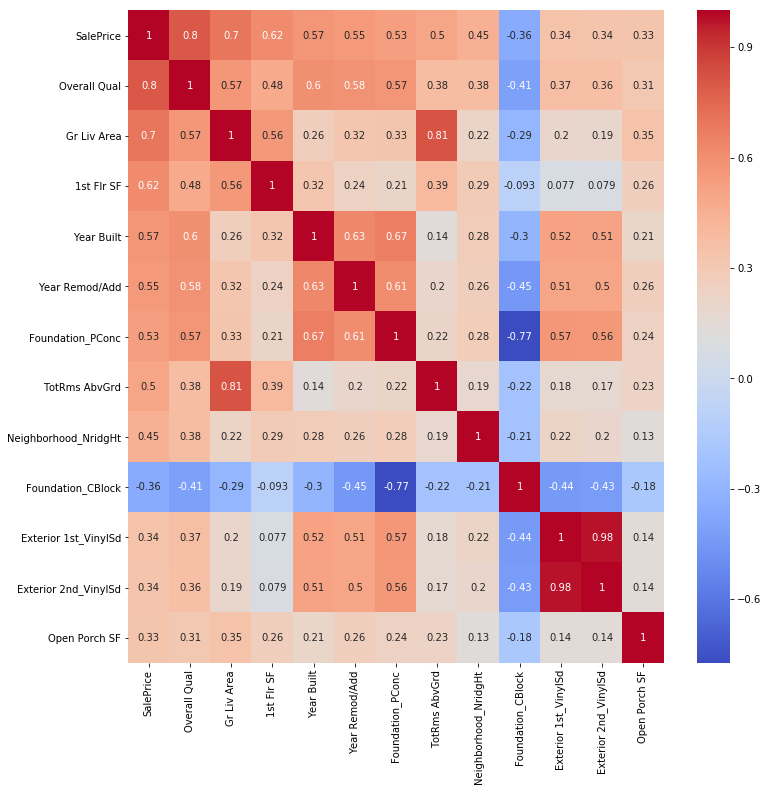

In [7]:
# check for colineiarity
plt.figure(figsize=(12,12))
sns.heatmap(df[corr_filter].corr(), annot=True, cmap = 'coolwarm')
plt.savefig('./images/complete_heatmap.png');

##### Heatmap to check for correlation

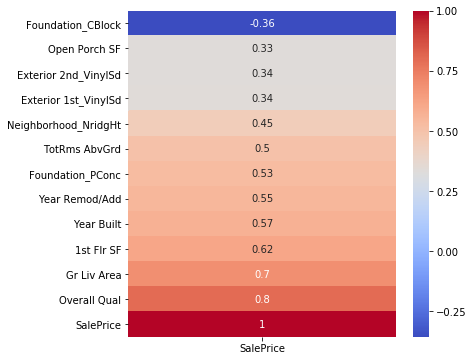

In [8]:
# correlation heatmap to sale price
plt.figure(figsize=(6, 6))
sns.heatmap(df[corr_filter].corr()[['SalePrice']].sort_values('SalePrice'), annot=True, cmap='coolwarm')
plt.savefig('./images/saleprice_heatmap.png');

##### Applied correlation mask to features

In [ ]:
X = df[corr_filter]
y = df['SalePrice']
correlation_model = model_comparison(X,y)

In [ ]:
correlation_model.lasso(params = lasso_params)

In [ ]:
correlation_model.ridge(params = ridge_params)

### Interaction Columns

Created many interaction terms and tested them in the model, below are the three that had the greatest positive impact on the model. Dropped original columns to avoid collinearity.

In [ ]:
#created a new feature that interacts Year Built and Year Remod/Add
df['year_interaction']= df['Year Built']* df['Year Remod/Add']

#created a new feature that interacts two types of porches
df['porch_interaction']= df['Open Porch SF'] * df['Wood Deck SF']

#created a new feature that interacts fireplaces and rooms above ground
df['fire_rooms']= df['Fireplaces'] * df['TotRms AbvGrd']

interaction_cols = ['Year Built', 'Year Remod/Add', 'Open Porch SF', 'Wood Deck SF', 'Fireplaces', 'TotRms AbvGrd']

##### Included interaction and filtered columns 

In [ ]:
X = df[corr_filter].drop(columns = interaction_cols)
y = df['SalePrice']
interaction_model = model_comparison(X,y)

In [ ]:
interaction_model.lasso(params = lasso_params)

In [ ]:
interaction_model.ridge(params = ridge_params)

###### Submission to kaggle

In [ ]:
submission_model = baseline_model.ridge_best_est

In [ ]:
y_pred = submission_model.predict(holdout)

In [ ]:
# load and test data at kaggle
y_pred = best_nums.predict(holdout.drop(columns = 'SalePrice'))
submission_df = holdout[["Id"]]
submission_df['SalePrice'] = y_pred
submission_df.to_csv('./datasets/submissions/baseline_submission.csv', index = False)